## Import libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import time
import os
import neat
import warnings
import graphviz
import visualize
import random
import glob
from IPython.display import clear_output

## Constants

In [34]:
WALL      = "x"
FREE_SPACE= "."
SAFE_ZONE = "H"
HIDER     = "h" 
SEEKER    = "s"

CHAR_MAPPING = {
    WALL      : -1,
    FREE_SPACE:  0,
    SAFE_ZONE :  1,
    HIDER     :  2, 
    SEEKER    :  3
}

COLOR_MAPPING = ["black", "white", "blue", "green", "red"]

MAP_SIMPLE_NAME = "map.txt"

ACTIONS = np.array([[-1,0], [1, 0], [0,-1], [0, 1]])
VISION = 1
SCENT = 5

STATE_SEEK = 0

REWARD =100000

## Map

In [35]:
class Map:
        
    def __init__(self,mapname, char_mapping):
        #read map
        with open(mapname, 'r') as map_file:
            lines = map_file.readlines()
            # width = int(lines[0])
            # height = int(lines[1])
            map_numbers = [[char_mapping[chr] for chr in row[:-1]] for row in lines[2:]]
        self.char_mapping =char_mapping
        self.map = np.array(map_numbers, dtype = np.int32)
        self.start_hider_pos = np.asarray(np.where(self.map == char_mapping[HIDER])).reshape(2)
        self.start_seeker_pos = np.asarray(np.where(self.map == char_mapping[SEEKER])).reshape(2)
        
        #action array for indexin
        self.action_indexer = tuple(ACTIONS.T.tolist())
        
        #initialize map and backup map
        self.map_layout = np.array(map_numbers, dtype = np.int32)
        self.map_layout[self.start_hider_pos[0] ,self.start_hider_pos[1] ] = char_mapping[FREE_SPACE]
        self.map_layout[self.start_seeker_pos[0],self.start_seeker_pos[1]] = char_mapping[FREE_SPACE]
        
        #initialize rewards
        self.hider_reward = np.zeros_like(self.map_layout)-1
        queue = np.where(self.map_layout==char_mapping[SAFE_ZONE])
        self.hider_reward[queue]=0
        queue = [(x,y)for x,y in zip(*queue)]
        while len(queue)>0:
            new_queue=[]
            for x,y in queue:
                for a_x,a_y in ACTIONS:
                    if (self.get_map_layout_pos([x+a_x,y+a_y])!=char_mapping[WALL] and
                        self.hider_reward[x+a_x,y+a_y]<0):
                            self.hider_reward[x+a_x,y+a_y]=self.hider_reward[x,y]+1
                            new_queue.append((x+a_x,y+a_y))
            queue=new_queue
        self.reset()
    
    def reset(self):
        self.hider_pos  =self.start_hider_pos
        self.seeker_pos =self.start_seeker_pos
        self.map = np.copy(self.map_layout)
        self.set_map_pos(self.hider_pos,  self.char_mapping[HIDER] )
        self.set_map_pos(self.seeker_pos, self.char_mapping[SEEKER])

        self.hider_reward_penalty = np.zeros_like(self.hider_reward)
        self.scent = np.zeros_like(self.map)

    def update(self):
        pos =self.hider_pos
        self.hider_reward_penalty[pos[0], pos[1]]+=1
        self.scent[pos[0],pos[1]]=SCENT
        self.scent-=1
        self.scent = np.clip(self.scent, 0, SCENT)
    
    def get_map_layout_pos(self,pos):
        return self.map_layout[pos[0], pos[1]]
    
    def set_map_pos(self,pos, value):
        self.map[pos[0], pos[1]] = value
    
    def get_agent_pos(self, agent):
        return self.hider_pos if agent ==HIDER else self.seeker_pos
    
    def set_agent_pos(self, agent, pos):
        if agent ==HIDER:
            self.hider_pos  =pos
        else:
            self.seeker_pos =pos
    
    def get_action_indicies(self, pos):
        return (
            self.action_indexer[0]+pos[0],
            self.action_indexer[1]+pos[1],
        )
    
    def get_percepts(self, agent, vision = 1):
        pos =self.get_agent_pos(agent)
        if agent==HIDER:
            return (self.map[self.get_action_indicies(pos)],[])
        else:
            percepts = self.map[
                pos[0] - vision : pos[0] + vision + 1,
                pos[1] - vision : pos[1] + vision + 1
            ]
            scent= np.append(self.scent[self.get_action_indicies(pos)],self.map[pos[0], pos[1]])
            return (percepts,scent) 

    def is_free(self, pos, agent):
        map_pos =self.get_map_layout_pos(pos)
        if (agent == HIDER):
            return (
                map_pos in [self.char_mapping[FREE_SPACE], self.char_mapping[SAFE_ZONE]] and
                not np.all(pos == self.seeker_pos)
            )
        else:
            return map_pos in [self.char_mapping[FREE_SPACE]]
            
    def move_agent(self, agent, new_pos):
        pos = self.get_agent_pos(agent)
        self.set_map_pos(pos,self.get_map_layout_pos(pos))
        self.set_map_pos(new_pos,self.char_mapping[agent])
        self.set_agent_pos( agent, new_pos)

    def do_action(self, agent, action):
        pos = self.get_agent_pos(agent)
        new_pos = pos + ACTIONS[action]
        if self.is_free(new_pos, agent):
            self.move_agent(agent, new_pos)
    
    def is_end(self):
        return np.all(self.hider_pos == self.seeker_pos)

    def get_reward(self,pos):
         return max(self.hider_reward[pos[0], pos[1]] - self.hider_reward_penalty[pos[0], pos[1]],0)

        
MAP = Map(MAP_SIMPLE_NAME,CHAR_MAPPING)

## Map visualization

In [36]:
def plot_map_jupiter_notebook(map:Map,gen):
    clear_output(wait=True)
    plt.figure()
    plt.title(f"Generation {gen}")
    plt.imshow(map.map, cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
    plt.show()
    
class Map_plot:
    def __init__(self, map:Map):
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.img = self.ax.imshow(map.map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
        
    def plot_map(self,map:Map, gen):
        self.ax.set_title(f"Generation {gen}")
        self.img.set_array(map.map)
        plt.draw()
        self.img.canvas.flush_events()

class Map_log:
    def __init__(self, log_name):
        self.dir = os.path.join("logs",log_name)

        self.logs = []
        files = glob.glob(os.path.join(self.dir,"*.npy"), recursive=True)
        for f in files:
            try:
                os.remove(f)
            except OSError as e:
                print("Error: %s : %s" % (f, e.strerror))
        
    def log_map(self,map:Map,gen):

        self.logs.append([map.hider_pos,map.seeker_pos])
        
    def save_and_reset(self, name):
        if not os.path.exists(self.dir):
            os.makedirs(self.dir)
        np.save(os.path.join(self.dir,name),self.logs)
        self.logs = []

## Evaluation

In [37]:
def eval_map_state(map:Map):
    dist = np.abs(map.hider_pos - map.seeker_pos).sum()

    if map.get_map_layout_pos(map.hider_pos) == CHAR_MAPPING[SAFE_ZONE]:
        state_hide = 0
    elif map.is_end():
        state_hide = -100000
    elif dist == 1:
        state_hide = -1000
    else:
        state_hide = (map.hider_pos**2).sum()

    if  map.is_end():
        state_seek = 100000
    elif dist == 1:
        state_seek = 1000
    else:
        state_seek = 0
    return (state_hide+10, state_seek-10)


def eval_map_state_hider(map:Map):
    state_hide = 1
    if map.get_map_layout_pos(map.hider_pos) == map.char_mapping[SAFE_ZONE]:
        state_hide = 0
    elif map.is_end():
        state_hide -= REWARD
    else:
        state_hide += map.get_reward(map.hider_pos)
    return state_hide

def eval_map_state_seeker(map:Map):
    state_seek=-1
    dist = np.abs(map.hider_pos - map.seeker_pos).sum()
    
    if  map.is_end():
        state_seek += REWARD
    else:
        state_seek += 1/dist
    return  state_seek


## Policies

In [38]:
def random_policy(map:Map, agent, **kwargs):
    percepts,scent = map.get_percepts(agent)
    perc_flat = percepts.reshape(-1)
    one_hot_in = np.zeros((len(perc_flat), len(map.char_mapping)))
    one_hot_in[np.arange(len(perc_flat)), perc_flat + 1] = 1 #WARNING value dependent
    input = np.concatenate([one_hot_in.reshape(-1),scent])
    return np.random.randint(len(ACTIONS)), 0


def NN_policy(map:Map, agent, **kwargs):
    percepts,scent = map.get_percepts(agent)
    perc_flat = percepts.reshape(-1)
    one_hot_in = np.zeros((len(perc_flat), len(map.char_mapping)))
    one_hot_in[np.arange(len(perc_flat)), perc_flat + 1] = 1 #WARNING value dependent
    
    #input = np.concatenate([one_hot_in.reshape(-1),scent])
    if agent == SEEKER:
        hider_pos = map.get_agent_pos(HIDER)
        seeker_pos = map.get_agent_pos(SEEKER)
        hider_seek_quadrant = np.clip(hider_pos - seeker_pos, -1, 1)
        input = np.hstack([perc_flat, hider_seek_quadrant])
        #perc_flat[perc_flat > 1] = 0
    else:
        input = perc_flat

    pos = map.get_agent_pos(agent)
    if agent == SEEKER:
        network = kwargs.get("seek_net")
    else:
        network = kwargs.get("hide_net")
        
    output = np.copy(network.activate(np.append(input, kwargs.get("state"))))
    state = output[-1]
    output = output[:-1]
    #output = np.copy(network.activate(percepts.reshape(-1)/3))

    #WARNING if not working coment region
    #region COMMENT 
    
    #while not map.is_free(
    #        pos + ACTIONS[np.argmax(output)],
    #        agent
    #    ): 
    #    output[np.argmax(output)] = -np.inf

    #end region

    return np.argmax(output), state

## Simulation

In [39]:
def simulate_step(map:Map, agent, policy, state, **kwargs):

    action, new_state = policy(map, agent, state = state, **kwargs)
    map.do_action(agent, action)
    return new_state     

def simulate(map:Map, map_eval, policy_hide, policy_seek, plot_func=None, num_steps = 100, **kwargs):
    seek_state = 0
    hide_state = 0
    map.reset()
    score = int(0)
    for step in range(num_steps):

        seek_state = simulate_step(map, SEEKER, policy_seek, seek_state, **kwargs)
        if(not map.is_end()):
            hide_state = simulate_step(map, HIDER, policy_hide, hide_state, **kwargs)

        if plot_func!=None:
            plot_func(map, kwargs.get("generation"))
        if map_eval!=None:
            score += map_eval(map)
            
        map.update()
        
        if(map.is_end()):
            break
    return score


### Simulation test


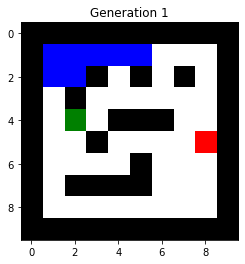

0

In [40]:
simulate(
    MAP, None,
    random_policy, random_policy,
    plot_map_jupiter_notebook,
    generation = 1, num_steps=50)

### Log test

In [41]:
log = Map_log("Test")

simulate(
    MAP, None,
    random_policy, random_policy,
    log.log_map,
    generation = 1, num_steps=50)

log.save_and_reset("random")

## NEAT

### Constants

In [42]:
CONFIG_PATH_HIDER = 'config-feedforward_hider'
CONFIG_PATH_SEEKER = 'config-feedforward_seeker'

CHECKPOINT_DIR="checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

#TODO fic parttools last two arguments
FIT_SIMULATION_STEPS = 30
EPOCHS = 30
GENERATION_SEEK = 10
GENERATION_HIDE = 2
NUM_OPONENTS = 8
FITNESS_HIDE_FILE = "./logs/fitness/best_hide.npy"
FITNESS_SEEK_FILE = "./logs/fitness/best_seek.npy"

SEEKER_FUNC=eval_map_state_seeker
HIDER_FUNC =eval_map_state_hider
POLICY_SEEKER =NN_policy
POLICY_HIDER =NN_policy 

### Fitness

In [43]:
def fitness_seek(genomes, config, map, hide_nets, config_hider):
    #print("FITNESS SEEK")
    fitness = 0
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for oponent_gene in hide_nets:
            fitness += int(simulate(
                map, SEEKER_FUNC,
                POLICY_HIDER,POLICY_SEEKER,
                num_steps = FIT_SIMULATION_STEPS, 
                seek_net = net,
                hide_net = neat.nn.FeedForwardNetwork.create(oponent_gene, config_hider)
            ))
        genome.fitness = fitness

def fitness_hide(genomes, config, map, seek_nets, config_seeker):
    #print("FITNESS HIDE")
    fitness = 0
    for genome_id, genome in genomes:     
        net = neat.nn.FeedForwardNetwork.create(genome, config)   
        for oponent_gene in seek_nets:
            fitness += int(simulate(
            map, HIDER_FUNC,
            POLICY_HIDER,POLICY_SEEKER,
            num_steps = FIT_SIMULATION_STEPS, 
            seek_net = neat.nn.FeedForwardNetwork.create(oponent_gene, config_seeker),
            hide_net = net))
        genome.fitness = fitness

### Evolution

In [44]:
def run_evolution(config_file_hider,config_file_seeker, map: Map, epochs = 80, log_name=None, log_step= 2,verbose=0):
    # Load configuration.
    config_seeker = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_file_seeker)
    config_hider = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file_hider)
    

    # Create the population, which is the top-level object for a NEAT run.
    seek_pop = neat.Population(config_seeker)
    if verbose>1:
        seek_pop.add_reporter(neat.StdOutReporter(True))
        seek_pop.add_reporter(neat.StatisticsReporter())
    seek_pop.add_reporter(neat.Checkpointer(GENERATION_SEEK,filename_prefix=os.path.join(CHECKPOINT_DIR,'seeker_')))

    hide_pop = neat.Population(config_hider)
    if verbose>1:
        hide_pop.add_reporter(neat.StdOutReporter(True))
        hide_pop.add_reporter(neat.StatisticsReporter())
    hide_pop.add_reporter(neat.Checkpointer(GENERATION_HIDE,filename_prefix=os.path.join(CHECKPOINT_DIR,'hider_')))

    winner_seek = neat.DefaultGenome(config_seeker)
    winner_hide = neat.DefaultGenome(config_hider)

    map_log = None
    if log_name!=None:
        map_log = Map_log(log_name)

    hide_winners = [winner_hide]
    seek_winners = [winner_seek]

    best_seek_fits = []
    best_hide_fits = []
    for epoch in range(epochs):
        if verbose>=0:
            print('_'*30,'EPOCH',epoch,'_'*30)
        # Run for up to 300 generations.
        log = map_log!=None and ((epoch % log_step)==0)
        
        #Seeker evolution
        if verbose>0:
            print('-'*30,'SEEKER','-'*30)
        selected_hide_winners = random.choices(hide_winners, k = NUM_OPONENTS)
        fit_seek_fixed = functools.partial(
            fitness_seek, map= map, hide_nets = selected_hide_winners, config_hider=config_hider
        )
        winner_seek = seek_pop.run(fit_seek_fixed, GENERATION_SEEK)
        seek_winners.append(winner_seek)
        fitness_seek([[0, winner_seek]],map = map, config = config_seeker, hide_nets= selected_hide_winners, config_hider=config_hider) #assigns fitness to winner
        best_seek_fits.append(winner_seek.fitness)
        
        
        seek_pop = neat.checkpoint.Checkpointer.restore_checkpoint(
            os.path.join(CHECKPOINT_DIR,"seeker_" + str( GENERATION_SEEK - 1)) 
        )
        seek_pop.add_reporter(neat.Checkpointer(GENERATION_SEEK,filename_prefix=os.path.join(CHECKPOINT_DIR,'seeker_')))

        if verbose>1:
            seek_pop.add_reporter(neat.StdOutReporter(True))
            seek_pop.add_reporter(neat.StatisticsReporter())

        if log:
            simulate(
                map,None,POLICY_HIDER, POLICY_SEEKER, plot_func=map_log.log_map,
                num_steps = FIT_SIMULATION_STEPS,
                hide_net = neat.nn.FeedForwardNetwork.create(winner_hide,config_hider),
                seek_net = neat.nn.FeedForwardNetwork.create(winner_seek,config_seeker)
            )
            map_log.save_and_reset(str(epoch*GENERATION_SEEK)+"Seeker")

        #Hider evolution
        if verbose>0:
            print('-'*30,'HIDER','-'*30)
        selected_seek_winners = random.choices(seek_winners, k = NUM_OPONENTS)
        fit_hide_fixed = functools.partial(
            fitness_hide, map= map, seek_nets = selected_seek_winners, config_seeker=config_seeker
        )
        winner_hide = hide_pop.run(fit_hide_fixed, GENERATION_HIDE)
        hide_winners.append(winner_hide)
        fitness_hide([[0, winner_hide]], config = config_hider, map = map, seek_nets= selected_seek_winners, config_seeker=config_seeker) #assigns fitness to winner
        best_hide_fits.append(winner_hide.fitness)
        hide_pop = neat.checkpoint.Checkpointer.restore_checkpoint(
            os.path.join(CHECKPOINT_DIR,'hider_'+ str( GENERATION_HIDE - 1))
        )
        hide_pop.add_reporter(neat.Checkpointer(GENERATION_HIDE,filename_prefix=os.path.join(CHECKPOINT_DIR,'hider_')))

        if verbose>1:
            hide_pop.add_reporter(neat.StdOutReporter(True))
            hide_pop.add_reporter(neat.StatisticsReporter())
        
        if log:
            simulate(
                map,None,POLICY_HIDER, POLICY_SEEKER, plot_func=map_log.log_map,
                num_steps = FIT_SIMULATION_STEPS,
                hide_net = neat.nn.FeedForwardNetwork.create(winner_hide,config_hider),
                seek_net = neat.nn.FeedForwardNetwork.create(winner_seek,config_seeker)
            )
            map_log.save_and_reset(str(epoch*GENERATION_HIDE)+"Hider")
    if log_step > 0:
        np.save(FITNESS_SEEK_FILE, np.array(best_seek_fits))
        np.save(FITNESS_HIDE_FILE, np.array(best_hide_fits))    
    return (winner_hide, winner_seek, config_hider,config_seeker)  
    

winner_hide, winner_seek, config_hider,config_seeker = run_evolution(
    CONFIG_PATH_HIDER,CONFIG_PATH_SEEKER,
    MAP, epochs=EPOCHS,
    log_step= 5,log_name="Neat_Test"
    )
#
    ##TODO adjust below
    ## Display the winning genome.
    #print('\nBest genome:\n{!s}'.format(winner))
#
    ## Show output of the most fit genome against training data.
    #print('\nOutput:')
    #winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    ##for xi, xo in zip(xor_inputs, xor_outputs):
    ##    output = winner_net.activate(xi)
    ##    print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))
#
    #node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    #visualize.draw_net(config, winner, True, node_names=node_names)
    #visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    #visualize.plot_stats(stats, ylog=False, view=True)
    #visualize.plot_species(stats, view=True)
#
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)

______________________________ EPOCH 0 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 1 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 2 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 3 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 4 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 5 ______________________________
Saving checkpoint to checkpoints\seeker_9
Saving checkpoint to checkpoints\hider_1
______________________________ EPOCH 6 ______________________________
Saving check

In [45]:
def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

res = draw_net(config_hider, winner_hide, True)
res = draw_net(config_seeker, winner_seek, True)

In [46]:
log = Map_log("Results")

simulate(
    MAP, None,  
    NN_policy, NN_policy,
    plot_func=log.log_map, num_steps=100,      
    hide_net = neat.nn.FeedForwardNetwork.create(winner_hide, config_hider),    
    seek_net = neat.nn.FeedForwardNetwork.create(winner_seek, config_seeker),  
    generation = GENERATION_SEEK * EPOCHS,
)

log.save_and_reset( str(GENERATION_SEEK * EPOCHS)+ " result")